# Imbalanced Dataset Training Test

아래처럼 실행
```
jupyter lab --ServerApp.iopub_msg_rate_limit=1.0e10
```

In [1]:
import os
import shutil
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

# Make Imbalaced Dataset

x_data: (150000, 10)
y_data: [134428, 15572]
x_train: (21800, 10)
y_train: [10900, 10900]
x_test: (45000, 10)
y_test: [40328, 4672]


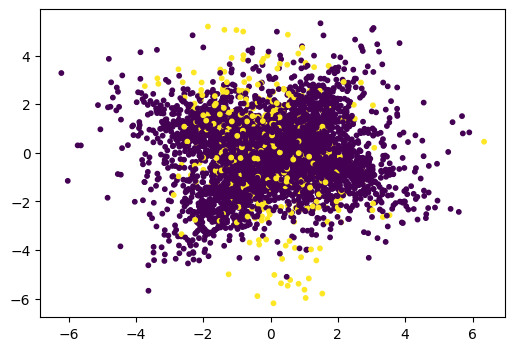

In [35]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

np.random.seed(0)
x_data, y_data = make_classification(
    n_samples=150000,
    n_features=8,
    n_informative=4,
    n_clusters_per_class=3,
    class_sep=0.6,
    weights=(0.9, 0.1),
    hypercube=False,
)
x_data = pd.DataFrame(x_data)
x_data.columns = [str(c) for c in x_data.columns]
x_data["rand1"] = np.random.rand(x_data.shape[0])
x_data["rand2"] = np.random.rand(x_data.shape[0])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, stratify=y_data)
rus = RandomUnderSampler(random_state=0)
x_train, y_train = rus.fit_resample(x_train, y_train)

print("x_data:", x_data.shape)
print("y_data:", pd.Series(y_data).value_counts().tolist())

print("x_train:", x_train.shape)
print("y_train:", pd.Series(y_train).value_counts().tolist())

print("x_test:", x_test.shape)
print("y_test:", pd.Series(y_test).value_counts().tolist())


pca = PCA(n_components=2)
pca_data = pca.fit_transform(x_data, y_data)
fig, plot = plt.subplots(1, figsize=(6, 4))
plot.scatter(pca_data[:5000, 0], pca_data[:5000, 1], c=y_data[:5000], marker="o", s=10)

# Model

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

weight = (y_test == 1).sum() / len(y_test)
model = LogisticRegression(class_weight=(weight, 1 - weight))
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

y_true_count = ((y_test == y_pred) & (y_pred != 0)).sum()

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print(f"{y_true_count} / {sum(y_test)} = {y_true_count / sum(y_test)}")

              precision    recall  f1-score   support

           0       0.92      0.62      0.74     40328
           1       0.15      0.56      0.23      4672

    accuracy                           0.62     45000
   macro avg       0.54      0.59      0.49     45000
weighted avg       0.84      0.62      0.69     45000

Accuracy : 0.6158222222222223
Precision: 0.14649181797803182
Recall   : 0.5595034246575342
F1 Score : 0.23219044235210518
2614 / 4672 = 0.5595034246575342


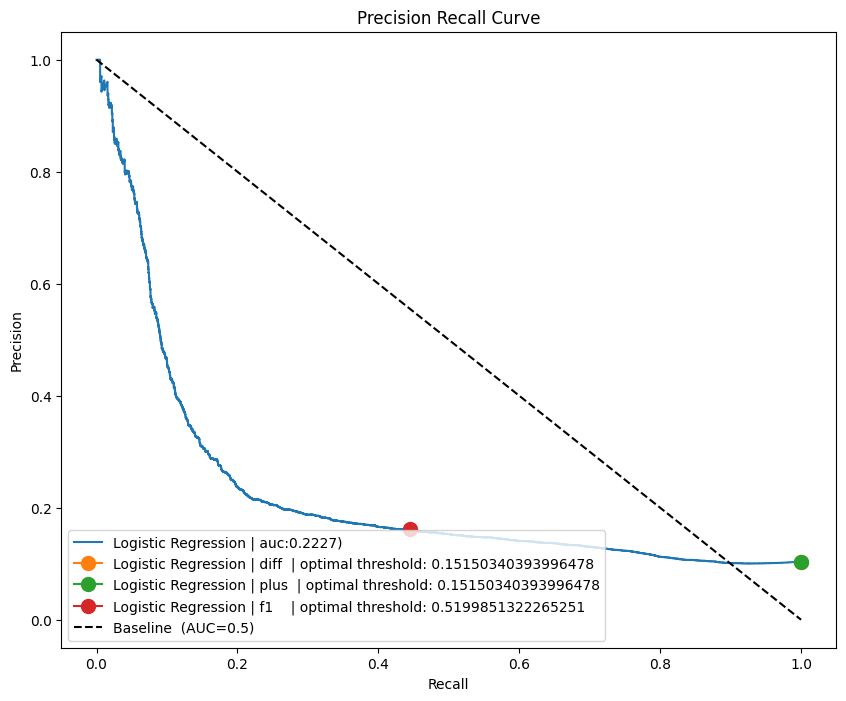

In [38]:
from sklearn.metrics import accuracy_score, auc, f1_score, precision_recall_curve


def calculate_prauc(y_true, y_prob, plot, label, method=[]):
    from collections.abc import Iterable

    def point_optimal_threshold(name):
        # Other Metrics at the max_threshold

        acc_ = accuracy_score(y_true, y_prob >= max_threshold)
        f1_ = f1_score(y_test, y_prob >= max_threshold)

        plot.plot(
            recall[max_idx],
            precision[max_idx],
            marker="o",
            markersize=10,
            label=f"{label} | {name:5} | optimal threshold: {max_threshold}",
        )

    if not isinstance(method, Iterable):
        method = [method]

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auc_ = auc(recall, precision)
    plot.plot(recall, precision, label=f"{label} | auc:{auc_:.4f})")

    # Optimize the thesholds
    best_threshold = None
    if "diff" in method:
        max_idx = np.argmax(recall - precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("diff")
        best_threshold = max_threshold

    if "plus" in method:
        max_idx = np.argmax(recall + precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("plus")
        best_threshold = max_threshold

    if "f1" in method:
        fscores = 2 * (precision * recall) / (precision + recall)
        max_idx = np.argmax(fscores)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("f1")
        best_threshold = max_threshold
    return best_threshold


y_prob = model.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "Logistic Regression", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

class_weight = {0: sum(train_labels == 1) / len(train_labels), 1: sum(train_labels == 0) / len(train_labels)}
model = DecisionTreeClassifier(max_depth=10)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

y_true_count = ((y_test == y_pred) & (y_pred != 0)).sum()

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print(f"{y_true_count} / {sum(y_test)} = {y_true_count / sum(y_test)}")

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     40328
           1       0.35      0.71      0.47      4672

    accuracy                           0.83     45000
   macro avg       0.65      0.78      0.68     45000
weighted avg       0.90      0.83      0.85     45000

Accuracy : 0.8301111111111111
Precision: 0.34591064579662073
Recall   : 0.7142551369863014
F1 Score : 0.46609400097772197
3337 / 4672 = 0.7142551369863014


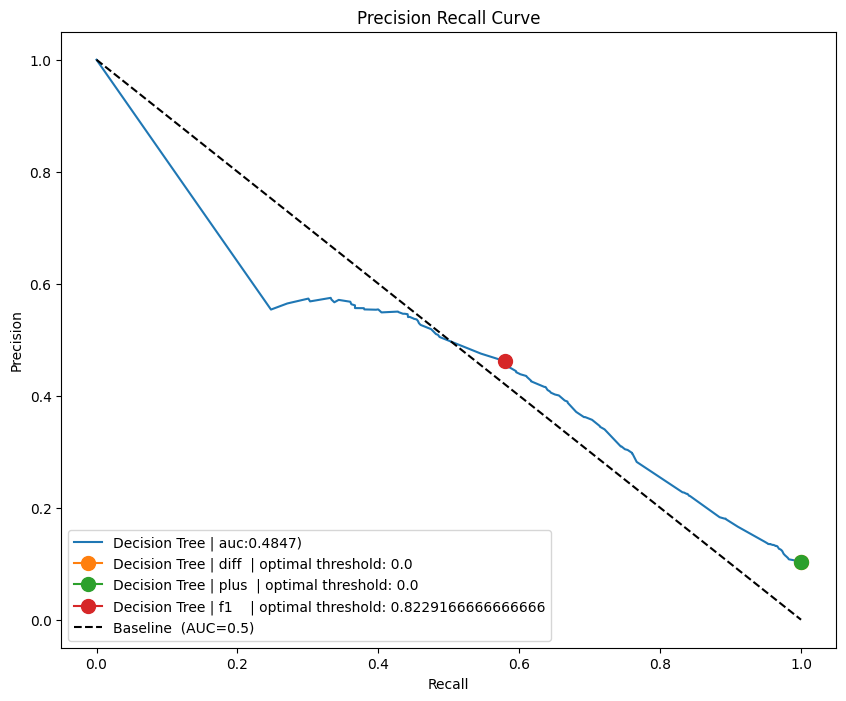

In [20]:
y_prob = model.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "Decision Tree", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## LightGBM

/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
scale_pos_weight: 0.5
Accuracy : 0.9255777777777778
Precision: 0.8247422680412371
Recall   : 0.3595890410958904
F1 Score : 0.500819794306156


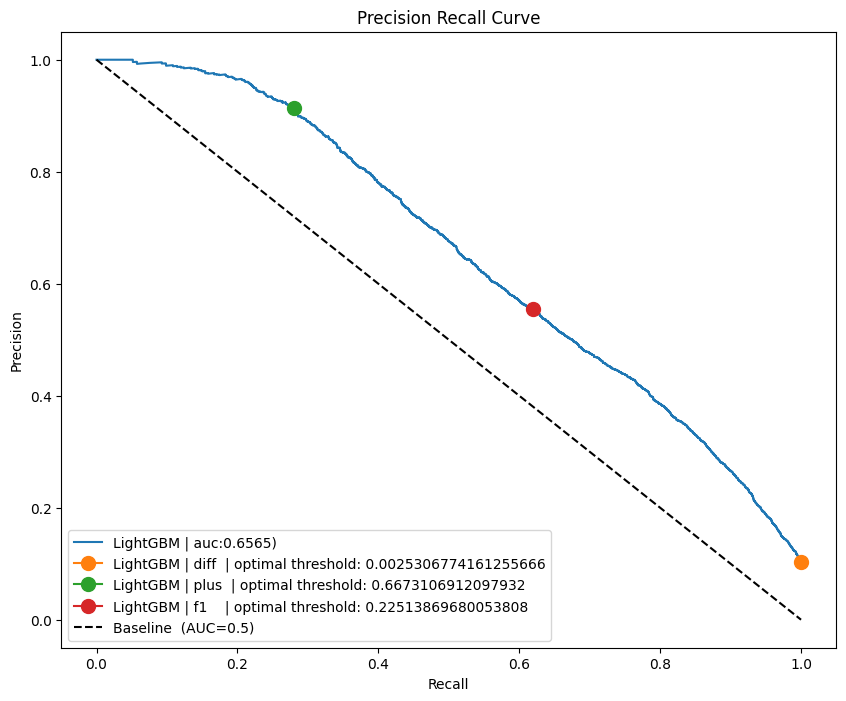

In [30]:
import lightgbm as lgb

train_features, valid_features, train_labels, valid_labels = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train
)

# scale_pos_weight = sum(train_labels == 0) / len(train_labels)
clf = lgb.LGBMClassifier(max_depth=30, n_estimator=400, random_state=100)
clf.fit(train_features, train_labels, eval_set=[(valid_features, valid_labels)], eval_metric="prauc", verbose=0)

y_pred = clf.predict_proba(x_test)[:, 1] >= 0.5

print("scale_pos_weight:", scale_pos_weight)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

y_prob = clf.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "LightGBM", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Deep Learning

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


model-epoch=09-val_loss=0.5821-val_prauc=0.8970.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8885777777777778
         test_f1            0.5832086450540316
        test_loss           0.7169543504714966
       test_prauc           0.6006572385891362
     test_precision         0.4767599891274803
       test_recall          0.7508561643835616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7169543504714966,
  'test_accuracy': 0.8885777777777778,
  'test_precision': 0.4767599891274803,
  'test_recall': 0.7508561643835616,
  'test_f1': 0.5832086450540316,
  'test_prauc': 0.6006572385891362}]

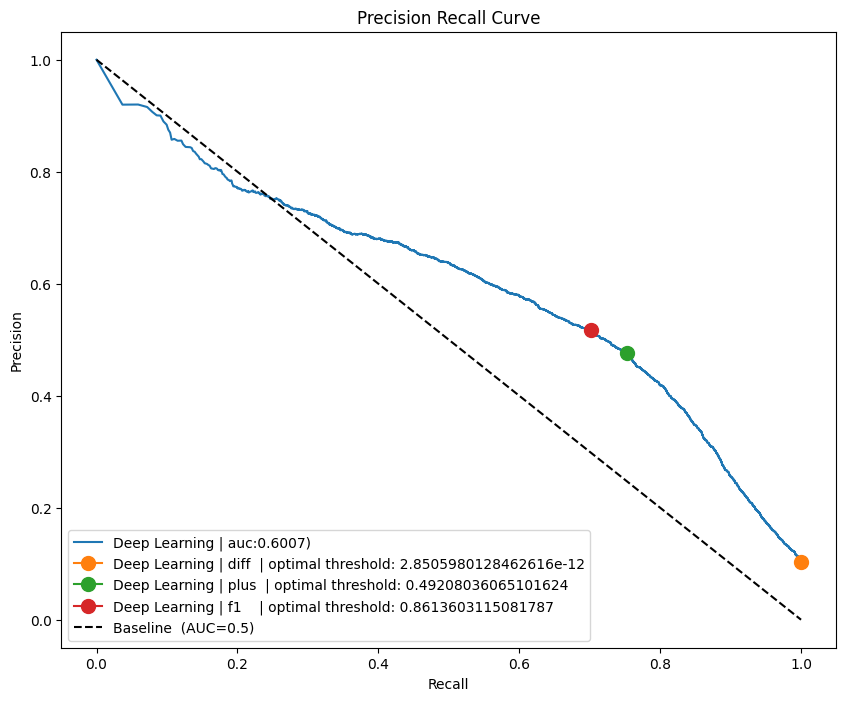

In [25]:
best_checkpoint_path = checkpoint_path / os.listdir(checkpoint_path)[0]
print(os.listdir(checkpoint_path)[0])
model = DeepLearningModel.load_from_checkpoint(best_checkpoint_path)
model.eval()
trainer.test(model, test_dataloader)

## Transformer

In [26]:
import math


class TransformerClassifier(BinaryClassifier):
    def __init__(self, d_model: int, nhead: int = 5, dim_feedforward: int = 64, num_layers: int = 6):
        super().__init__()
        self.save_hyperparameters()
        self.encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)
        self.d_model = d_model
        self.loss = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())


# 모델 훈련
pl.seed_everything(1000)
checkpoint_path = Path(gettempdir()) / "anderson_ml" / "pytorch_transformer" / "checkpoints"
checkpoint_callback = ModelCheckpoint(
    monitor="val_prauc",
    dirpath=checkpoint_path,
    filename="model-{epoch:02d}-{val_loss:.4f}-{val_prauc:.4f}",
    verbose=False,
    save_top_k=1,
    mode="max",
)

if checkpoint_path.exists():
    shutil.rmtree(checkpoint_path)
model = TransformerClassifier(d_model=x_train.shape[1])
trainer = pl.Trainer(max_epochs=30, gpus=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader, valid_dataloader)

Global seed set to 1000
/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type        

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


model-epoch=27-val_loss=0.3648-val_prauc=0.9221.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8704222222222222
         test_f1            0.5598913125518907
        test_loss           0.3940180242061615
       test_prauc           0.6655901492804714
     test_precision         0.4324355835373674
       test_recall          0.7938784246575342
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3940180242061615,
  'test_accuracy': 0.8704222222222222,
  'test_precision': 0.4324355835373674,
  'test_recall': 0.7938784246575342,
  'test_f1': 0.5598913125518907,
  'test_prauc': 0.6655901492804714}]

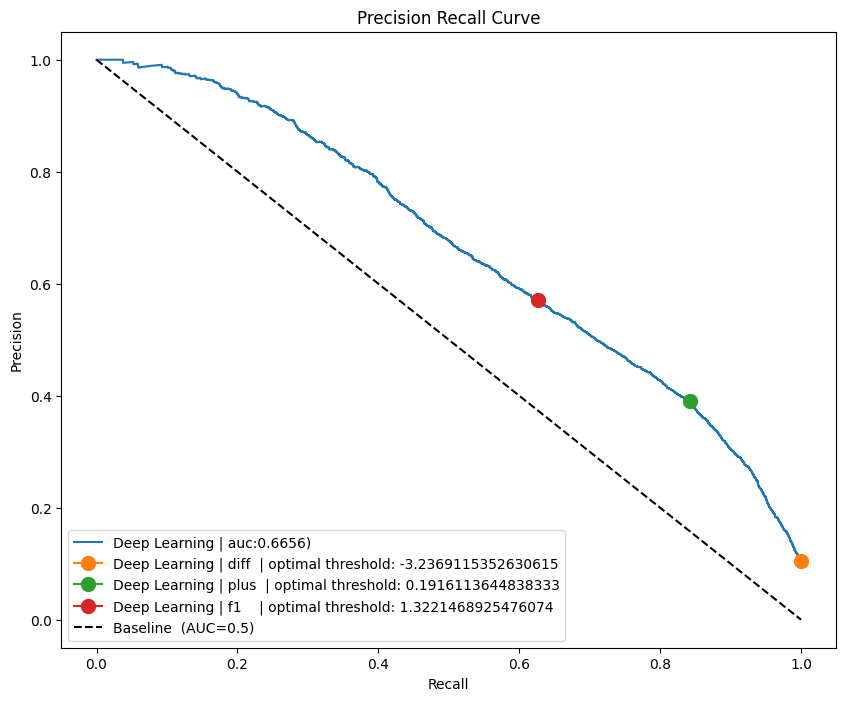

In [27]:
best_checkpoint_path = checkpoint_path / os.listdir(checkpoint_path)[0]
print(os.listdir(checkpoint_path)[0])
model = TransformerClassifier.load_from_checkpoint(best_checkpoint_path)
model.eval()
trainer.test(model, test_dataloader)